In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import v2

seed = 42
np.random.seed(seed)

mainfolder = r"./compressed_dataset"


In [2]:
# We use this data to choose a random country from which to choose an image out
# of all og the countries. We will generate batches with this.

# Amount of images per country
data_per_country = {}

# Mappings country -> Int and viceversa
country_to_int = {}
int_to_country = {}

# Number of countries (is updated after for loop)
number_countries = 0

# Total amount of images
total_data = 0

i = 0
for country in os.listdir(mainfolder):

    country_to_int[country] = i
    int_to_country[i] = country
    i += 1

    amount = len(os.listdir(os.path.join(mainfolder, country)))
    data_per_country[country] = amount
    total_data += amount

number_countries = i

probabilities = [0]*number_countries


for key, value in data_per_country.items():
    probabilities[country_to_int[key]] = value/total_data


print(country_to_int)
print(int_to_country)
print(data_per_country)
print(probabilities)
print(total_data, number_countries)

{'Bhutan': 0, 'Kenya': 1, 'Botswana': 2, 'Poland': 3, 'Tunisia': 4, 'Eswatini': 5, 'Belarus': 6, 'Sweden': 7, 'Russia': 8, 'Norway': 9, 'Tanzania': 10, 'Luxembourg': 11, 'Sri Lanka': 12, 'Brazil': 13, 'Faroe Islands': 14, 'Kyrgyzstan': 15, 'Ghana': 16, 'US Virgin Islands': 17, 'San Marino': 18, 'Ukraine': 19, 'Svalbard and Jan Mayen': 20, 'France': 21, 'Jersey': 22, 'American Samoa': 23, 'Ecuador': 24, 'Nepal': 25, 'South Sudan': 26, 'Bermuda': 27, 'Guatemala': 28, 'Belgium': 29, 'Gibraltar': 30, 'Turkey': 31, 'Netherlands': 32, 'Guam': 33, 'Hong Kong': 34, 'Malaysia': 35, 'Indonesia': 36, 'Estonia': 37, 'Iraq': 38, 'Spain': 39, 'Montenegro': 40, 'Costa Rica': 41, 'Macao': 42, 'Serbia': 43, 'South Korea': 44, 'Croatia': 45, 'Australia': 46, 'Northern Mariana Islands': 47, 'Myanmar': 48, 'Lesotho': 49, 'Latvia': 50, 'United Kingdom': 51, 'Qatar': 52, 'Germany': 53, 'Laos': 54, 'Nigeria': 55, 'Albania': 56, 'Mongolia': 57, 'Uruguay': 58, 'Venezuela': 59, 'Slovakia': 60, 'Argentina': 61, 

In [10]:
# Creating test split: we take the name of 0.1 images from each country and add them to a dictionary,
# this dictionary will represent out test split.

percentage = 0.1

# This dictionary represents test split
test_images = {}
test_size = 0

# Loop through filesystem adding 'percentage*(the amount of images that a certain country has)' distinct images from that country
for country, amount_data in data_per_country.items():
    test_images[country] = []
    for i in range(int(amount_data*percentage)):
        image_name = os.listdir(os.path.join(mainfolder, country))[i]
        test_images[country].append(image_name)
    test_size += int(amount_data*percentage)


print(test_images)
print(test_size)


{'Bhutan': ['canvas_1629262074.jpg', 'canvas_1629527767.jpg'], 'Kenya': ['canvas_1629925277.jpg', 'canvas_1629837897.jpg', 'canvas_1630278825.jpg', 'canvas_1629433275.jpg', 'canvas_1630286494.jpg', 'canvas_1629420802.jpg', 'canvas_1629692576.jpg', 'canvas_1629738400.jpg', 'canvas_1629732477.jpg', 'canvas_1629956926.jpg', 'canvas_1629398720.jpg', 'canvas_1629279870.jpg', 'canvas_1629284902.jpg'], 'Botswana': ['canvas_1629747028.jpg', 'canvas_1629733030.jpg', 'canvas_1629513416.jpg', 'canvas_1629913698.jpg', 'canvas_1629685585.jpg', 'canvas_1629851468.jpg', 'canvas_1630336815.jpg', 'canvas_1630269097.jpg', 'canvas_1629588192.jpg', 'canvas_1630141984.jpg', 'canvas_1629766797.jpg', 'canvas_1629394047.jpg', 'canvas_1630272517.jpg', 'canvas_1629714843.jpg'], 'Poland': ['canvas_1630094174.jpg', 'canvas_1629536669.jpg', 'canvas_1629770684.jpg', 'canvas_1629593955.jpg', 'canvas_1630215808.jpg', 'canvas_1630078484.jpg', 'canvas_1629784261.jpg', 'canvas_1629475220.jpg', 'canvas_1629534268.jpg', '

In [33]:
###
###     Gets 'n' images with a certain probability distrubution for choosing countries.
###     If this is None there will be the same probability when choosinf country A and country B
###
###     ATENTTION: this functions gets images avoiding those in the test split
###


def get_N_Images(n, path=mainfolder, probabilities=None):
    """
        Gets 'n' images of the dataset with probabilities 'probabilities' for each country.
        If this is None it get's images with equal probability
    """

    processed_images = torch.empty(n,3,224,224) # ResNet's input size
    labels = torch.empty(n)

    # Define transformation to apply to images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Iterate over n random images
    for i in range(n):

        # This randomly chose indice will dictate what country the image is chose from
        country = np.random.choice(os.listdir(path), p=probabilities)

        # Choose a random image from the selected country folder that's not in test_split
        image_name = np.random.choice(os.listdir(os.path.join(path, country))[int(data_per_country[country]*percentage):])

        # Load and process the image
        image_path = os.path.join(path, country, image_name)
        image = Image.open(image_path)
        processed_image = transform(image)

        # Append the processed image to the list
        processed_images[i] =  processed_image.unsqueeze(0)

        # Append the label
        labels[i] = country_to_int[country]

    return processed_images, labels.long()

###
### A Functions for getting countries with more than threshold images
###
###     Usage: Call 'l = get_countries_threshold(1000)' to get a list of countries with more than 1000 images.
###

def get_countries_threshold(threshold, path=mainfolder):
    """
        Gets list of countries with more or 'n' images.
    """
    countries_threshold = []

    for country in os.listdir(path):
        if len(os.listdir(os.path.join(path, country))) >= threshold:
            countries_threshold.append(country)
    
    return countries_threshold

###
###     Gets images and augments the ones from countries with less than threshold images
###
###     ATENTTION: this functions gets images avoiding those in the test split
###

def get_N_Images_Augmentation(n, threshold, path=mainfolder):
    """
        Gets images 'n' from countries with data augmentation for
        countries with less than 'threshold' images
    """
    processed_images = torch.empty(n,3,224,224) # ResNet's inpoyut size
    labels = torch.empty(n)

    # Define transformation to apply to images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Data augmentation transforms
    data_augmentation_transform = v2.Compose([
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomRotation(3),
    ])

    countries_threshold = get_countries_threshold(threshold, path=path)

    # Iterate over n random images
    for i in range(n):
        # This randomly chose indice will dictate what country the image is chose from
        country = np.random.choice(os.listdir(path))

        # Choose a random image from the selected country folder that's not in test_split
        image_name = np.random.choice(os.listdir(os.path.join(path, country))[int(data_per_country[country]*percentage):])

        # Load and process the image
        image_path = os.path.join(path, country, image_name)
        image = Image.open(image_path)
        processed_image = transform(image)

        if country not in countries_threshold:
            processed_image = data_augmentation_transform(processed_image)

        # Append the processed image to the list
        processed_images[i] =  processed_image.unsqueeze(0)

        # Append the label
        labels[i] = country_to_int[country]

    return processed_images, labels.long()

['Russia', 'Brazil', 'France', 'Spain', 'Australia', 'United Kingdom', 'United States', 'Japan', 'South Africa', 'Finland', 'Canada']

torch.Size([5, 3, 224, 224])

torch.Size([5, 3, 224, 224])

Kenya


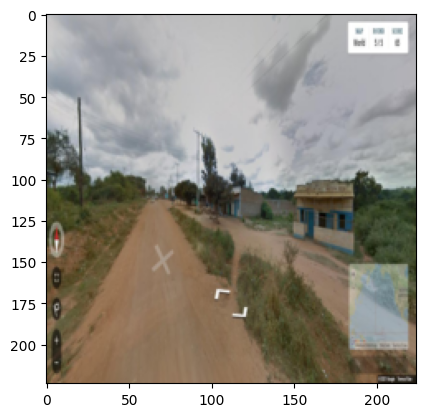

In [37]:
print(get_countries_threshold(1000))
print()

data, _ = get_N_Images(5)

print(data.size())
print()

data, labels = get_N_Images_Augmentation(5, 1)

print(data.size())
print()

print(int_to_country[labels[0].item()])
plt.imshow(data[0].permute(1, 2, 0))

In [38]:
#from tqdm.notebook import tqdm # This gives me erros :(
import torch.nn.functional as F

def train_augmented(model, n=20, nepoch=120, lr=1e-2, step_size=10, threshold=1000):

    """
    Train 'model' on 'nepoch' epochs of size 'n' with augmentatiob.

    This training gets images from countries with an equal probability and augments them if it's from
    a country with less then 'threshold' images. Then it feeds them to the model and trains. It does this
    for 'n' images for 'nepoch' times.

    Parameters:
        - 'model'
        - 'n': n images per batch
        - 'nepoch'
        - 'lr'
        - 'step_size': number of epochs after which lr is sacled
        - 'threshold': amount of images for which if a country has less than this we augment
    """
    # Criterion, optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    # Training process. Note: we are not using a validation set
    try:
        for epoch in range(nepoch): #tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            
            inputs, labels = get_N_Images_Augmentation(n, threshold)

            #inputs = inputs.cuda()
            #labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_for_epoch = loss.item()

            print(f"Loss for epoch {epoch} is {loss_for_epoch:.6f}")
        scheduler.step()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return


def train(model, n=20, nepoch=120, lr=1e-2, step_size=10, probabilities=None):
    """
    Train 'model' on 'nepoch' epochs of size 'n'

    Parameters:
        - 'model'
        - 'n': n images per batch
        - 'nepoch'
        - 'lr'
        - 'step_size': number of epochs after which lr is sacled
        - 'probabilities': probabilty distrubution with which we pick countries. It can be used
            to scue the image collection more towrds countries with more data.
    """
    # Criterion, optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    # Training process. Note: we are not using a validation set
    try:
        for epoch in range(nepoch): #tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            
            inputs, labels = get_N_Images(n, probabilities=probabilities)

            #inputs = inputs.cuda()
            #labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_for_epoch = loss.item()

            print(f"Loss for epoch {epoch} is {loss_for_epoch:.6f}")
        scheduler.step()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

In [42]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)#.cuda()

Using cache found in /Users/guille/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/anaconda3/envs/jupyter_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/jupyter_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
train(model, n=600, nepoch=30, lr=1e-1, step_size=10, probabilities=probabilities)

EPOCH 0


In [ ]:
torch.save(model.state_dict(), "NotAugmentedGeoModel")

In [ ]:
model_augmentation = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)#.cuda()

train_augmented(model_augmentation, n=600, nepoch=20, lr=1e-1, step_size=20, threshold=1000)

In [30]:
torch.save(model.state_dict(), "AugmentedGeoModel")